# Lab 2: Clustering

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD2"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L2_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

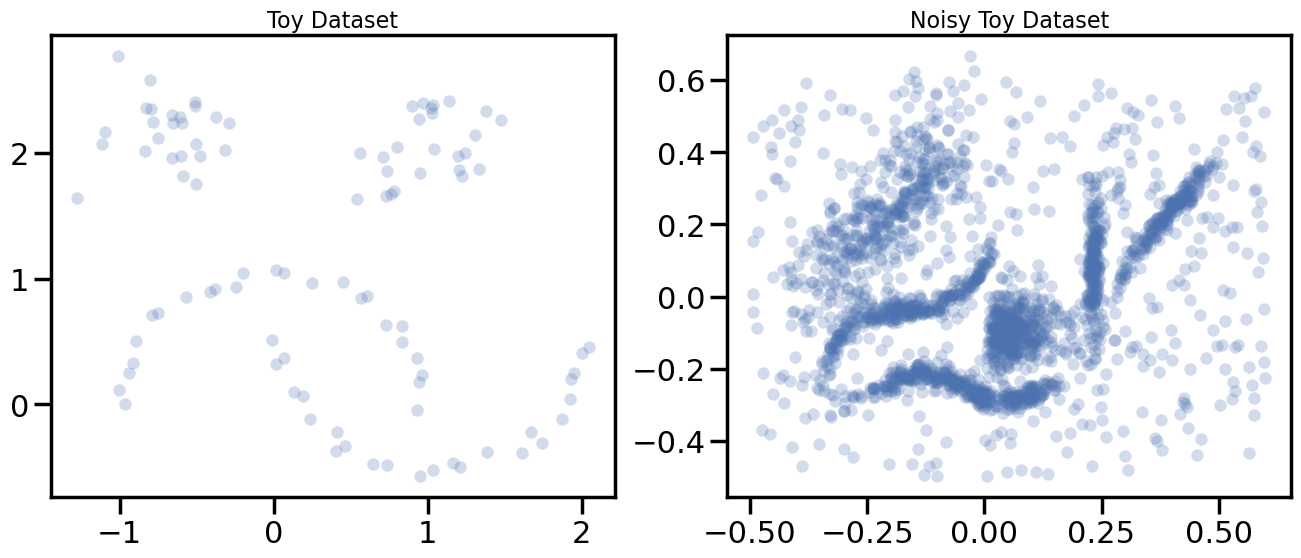

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

## Aglomerative Single Linkage clustering

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


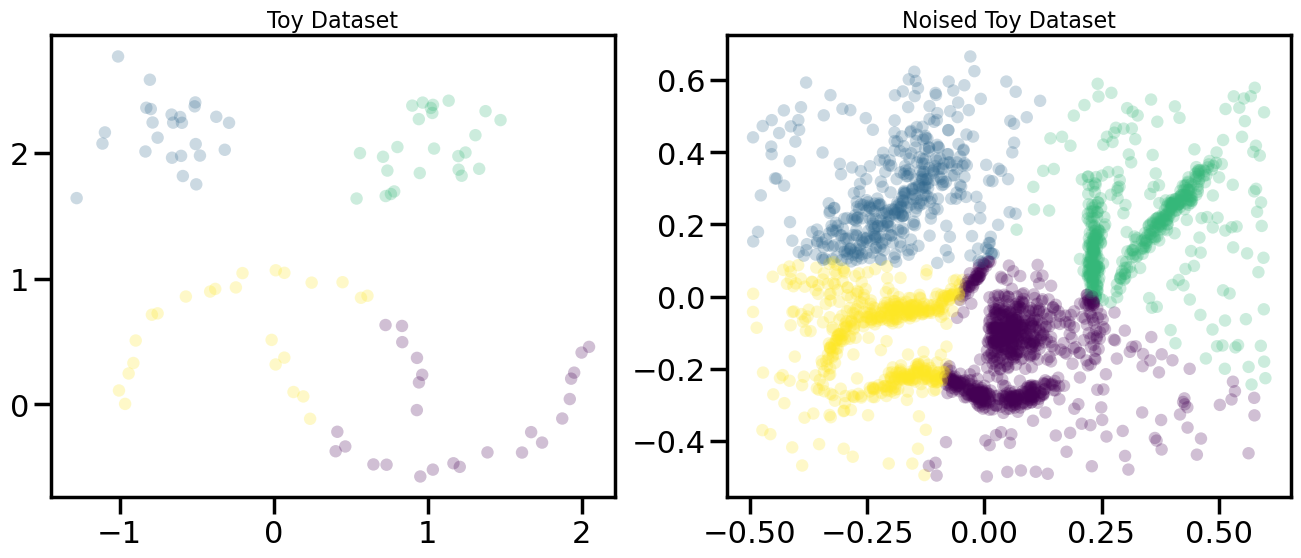

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, fcluster


class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        
    def fit(self, X):
        
        n = X.shape[0]

        if self.metric_ == "precomputed":
            D = X.copy()
        else:
            D = distance.squareform(distance.pdist(X, metric=self.metric_))
        
        # La diagonale de la matrice des distances contient la distance d'un point à lui-même (0)
        # On la met à inf pour qu'elle ne soit pas prise en compte dans la recherche du min      
        np.fill_diagonal(D, np.inf)

        clusters = {i: [i] for i in range(n)}
        real_ids = np.arange(n)
        linkage_rows = []

        for i in range(n - 1):
            
            id1, id2 = np.unravel_index(np.argmin(D), D.shape)

            dist = D[id1, id2]

            id1_real = real_ids[id1]
            id2_real = real_ids[id2]
            
            num_points = len(clusters[id1]) + len(clusters[id2])
            linkage_rows.append([id1_real,id2_real, dist, num_points])

            # On modifie les colonnes et lignes de D avec le nouveau cluster au lieu de rajouter une ligne et une colonne pour des raisons de complexité
            # On choisit l'un des deux clusters pour qui on modifie la ligne avec les nouvelles distances et on met l'autre cluster à inf
            D[:, id1] = np.minimum(D[:, id1], D[:, id2])
            D[id1, :] = D[:, id1]
            D[:, id2] = np.inf
            D[id2, :] = np.inf

            # Réinitialiser la diagonale à inf après la maj pour éviter qu'un cluster ne se fusionne avec lui-même
            np.fill_diagonal(D, np.inf)
            
            clusters[id1].extend(clusters[id2])
            clusters[id2] = []
            
            real_ids[id1] = n + i
            
        self.linkage_matrix_ = np.array(linkage_rows)
        self.labels_ = fcluster(self.linkage_matrix_, self.n_clusters_, criterion='maxclust') - 1
        
        return self
        
    def plot_dendrogram(self):
        plt.figure()
        plt.title('Dendrogramme')
        plt.xlabel('Clusters')
        plt.ylabel('Distance')
        dendrogram(self.linkage_matrix_)
        plt.show()

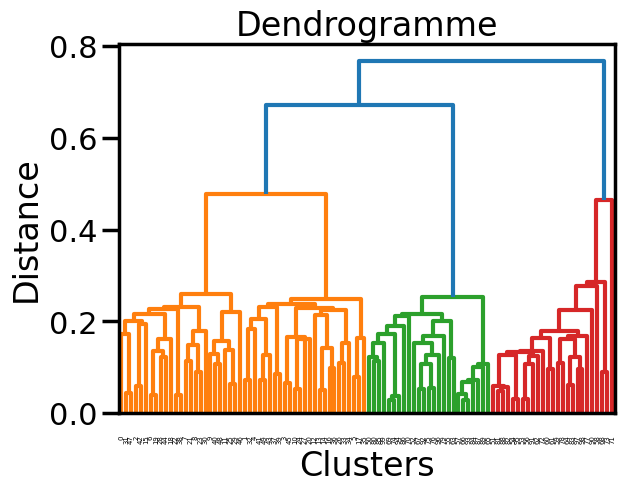

In [5]:
Model = my_SingleLinkageAglomerativeClustering()
Model.fit(test_data_0)
Model.plot_dendrogram()

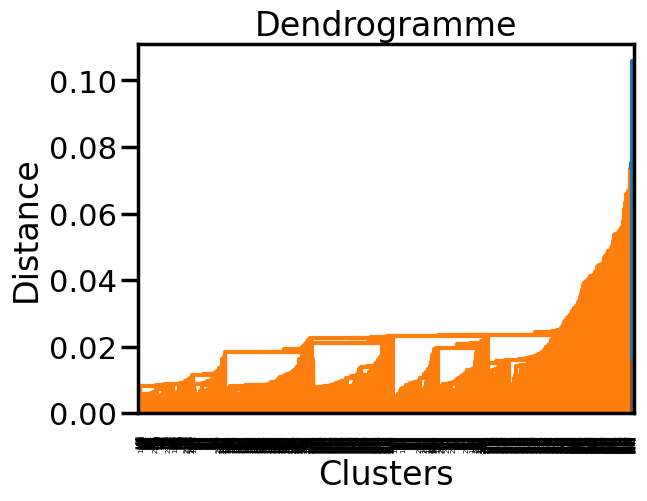

In [6]:
Model = my_SingleLinkageAglomerativeClustering()
Model.fit(test_data_1)
Model.plot_dendrogram()

Apply the method to our toy datasets

Text(0.5, 1.0, 'Noised Toy Dataset')

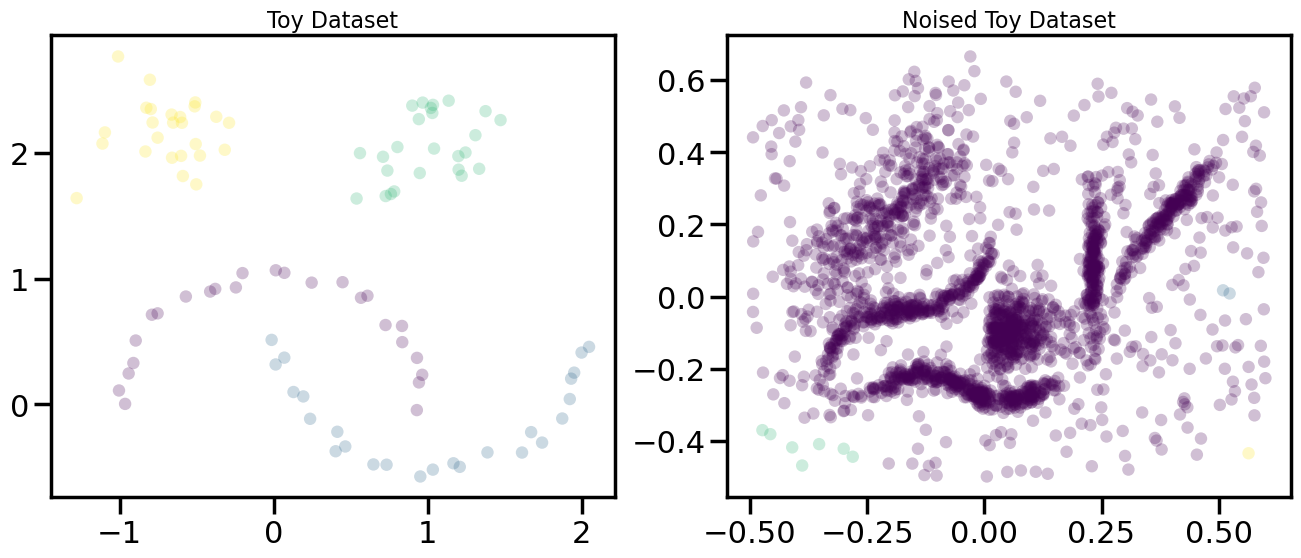

In [7]:
#aplly to our datasets
Model_1 = my_SingleLinkageAglomerativeClustering(n_clusters=4)
Model_1.fit(test_data_0)
Model_2 = my_SingleLinkageAglomerativeClustering(n_clusters=4)
Model_2.fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=Model_1.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=Model_2.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)




Try the different linkage methods implemented in `sklearn`  and comment

On essaye le single Model de sklearn

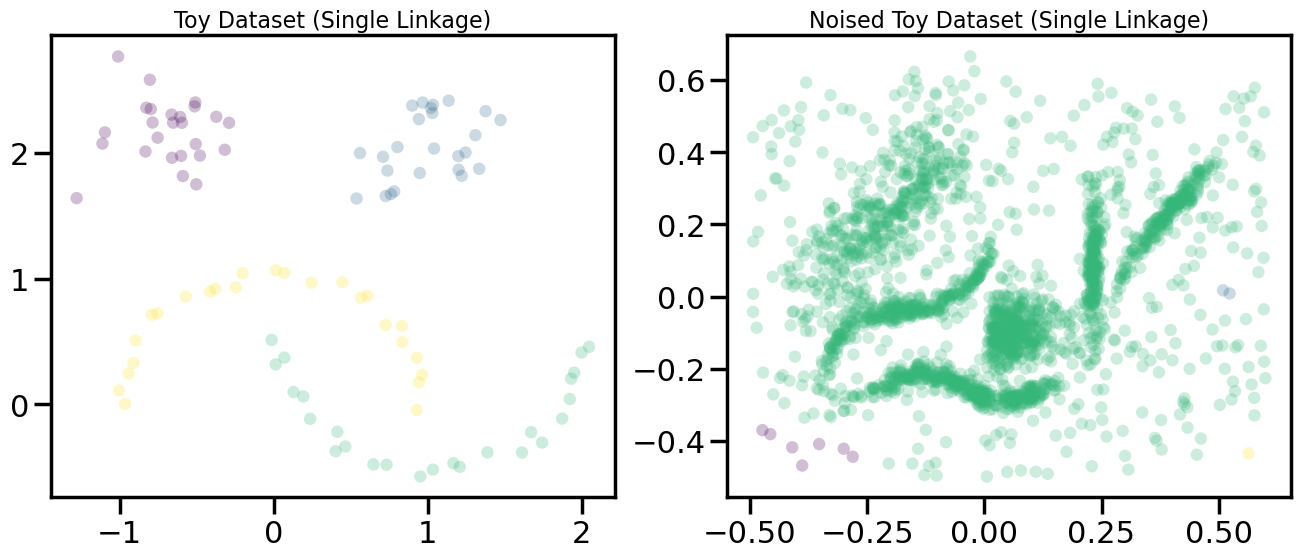

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
import numpy as np 


linkage_single_0 = linkage(test_data_0, method='single', metric='euclidean')
labels_single_0 = fcluster(linkage_single_0, 4, criterion='maxclust') - 1

linkage_single_1 = linkage(test_data_1, method='single', metric='euclidean')
labels_single_1 = fcluster(linkage_single_1, 4, criterion='maxclust') - 1


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels_single_0, **plot_kwds)
ax[0].set_title('Toy Dataset (Single Linkage)', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels_single_1, **plot_kwds)
ax[1].set_title('Noised Toy Dataset (Single Linkage)', size=16)


plt.show()

Le single model donne le même résultat que celui construit à l'étape d'avant, on essaye maintenant d'autres modèles: on commence par le complete

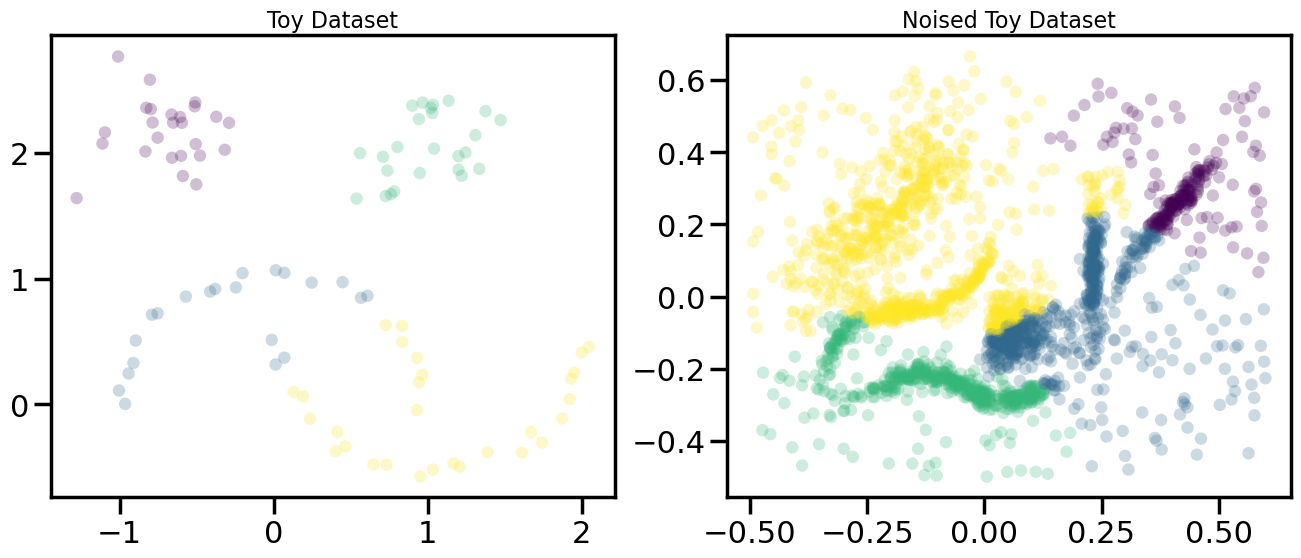

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


linkage_complete_0 = linkage(test_data_0,method='complete', metric='euclidean')
labels_complete_0 = fcluster(linkage_complete_0, 4, criterion='maxclust') - 1
linkage_complete_1 = linkage(test_data_1,method='complete', metric='euclidean')
labels_complete_1 = fcluster(linkage_complete_1, 4, criterion='maxclust') - 1


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels_complete_0 , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels_complete_1, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show()

Average Model

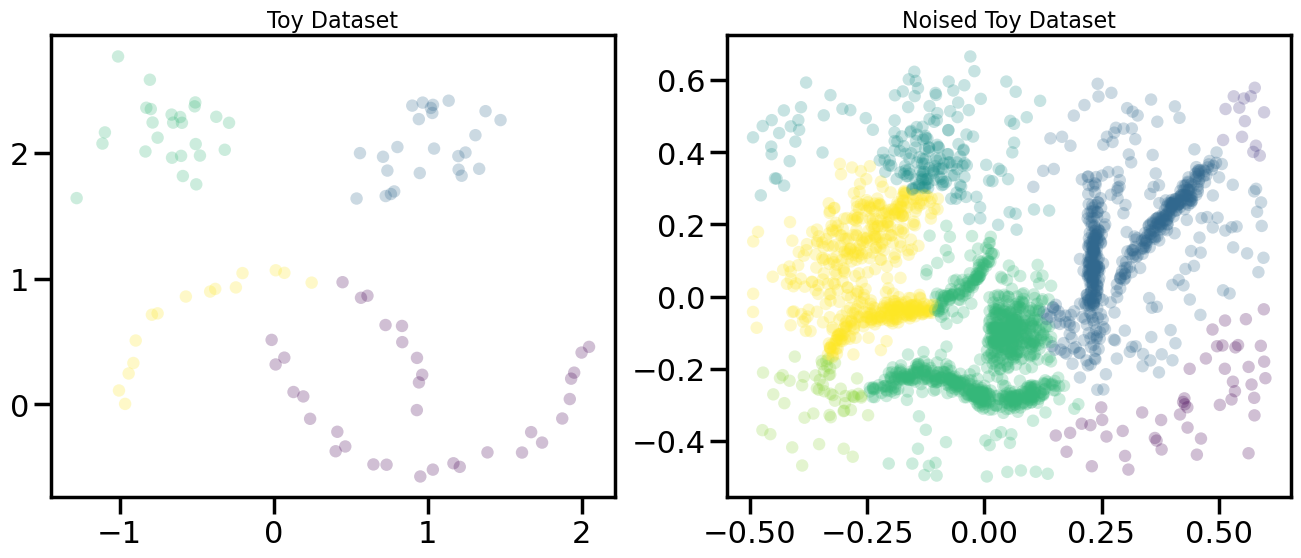

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


linkage_average_0 = linkage(test_data_0,method='average', metric='euclidean')
labels_average_0 = fcluster(linkage_average_0, 4, criterion='maxclust') - 1
linkage_average_1 = linkage(test_data_1,method='average', metric='euclidean')
labels_average_1 = fcluster(linkage_average_1, 7, criterion='maxclust') - 1


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels_average_0 , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels_average_1, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show()

for the not noisy dataset, the single gives the best results, but for the noisy one, the complete and average give better results finding the clusters but it's still not that good because of the noise

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

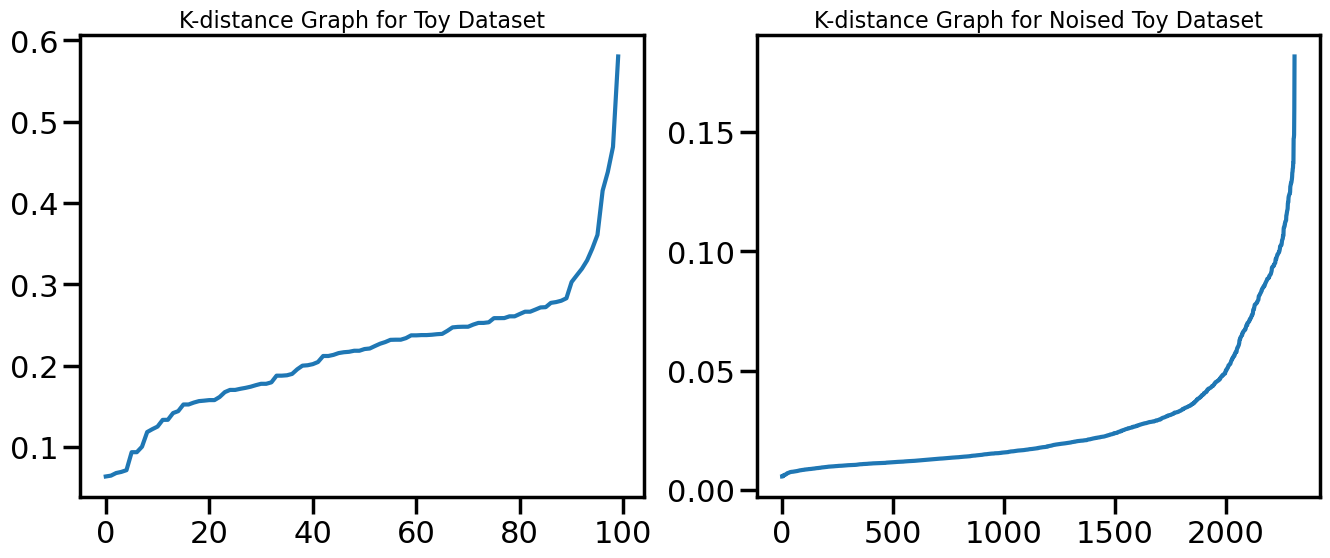

In [11]:
# to tune epsilon, let's use the elbow trick
# but before we should fix the MinPts 
# for dataset 0, which is not noisy, we can take a common value of MinPts = 4
# for dataset 1, which is noisy, we can take a bigger minPts because it's more dense, let's say MinPts = 10
# and then plot the k-distance graph for each dataset and see where the elbow is located

from sklearn.neighbors import NearestNeighbors

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
neighbors_0 = NearestNeighbors(n_neighbors=4)
neighbors_0_fit = neighbors_0.fit(test_data_0)
distances_0, indices_0 = neighbors_0_fit.kneighbors(test_data_0)
distances_0 = np.sort(distances_0[:,3], axis=0)
ax[0].plot(distances_0)
ax[0].set_title('K-distance Graph for Toy Dataset', size=16)


neighbors_1 = NearestNeighbors(n_neighbors=10)
neighbors_1_fit = neighbors_1.fit(test_data_1)
distances_1, indices_1 = neighbors_1_fit.kneighbors(test_data_1)
distances_1 = np.sort(distances_1[:,9], axis=0)
ax[1].plot(distances_1)
ax[1].set_title('K-distance Graph for Noised Toy Dataset', size=16)
plt.show()


Text(0.5, 1.0, 'Noised Toy Dataset')

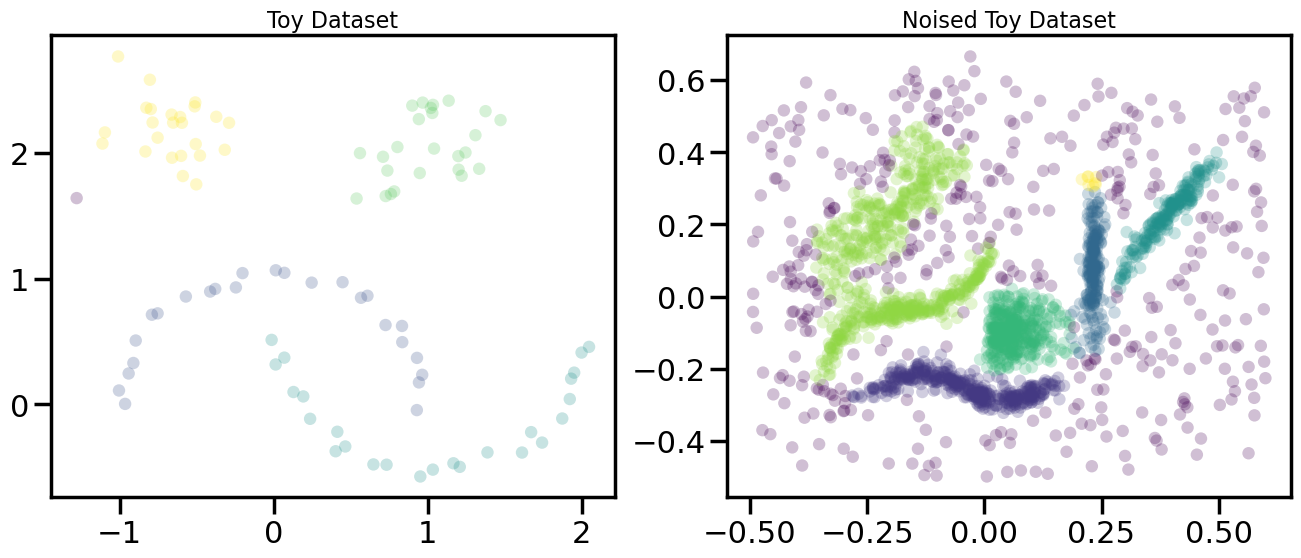

In [12]:
#So we can see that the elbow for the first dataset is around 0.3 and for the second one it's around 0.03

from sklearn.cluster import DBSCAN
dbscan_0 = DBSCAN(eps=0.3, min_samples=3).fit(test_data_0)
dbscan_1 = DBSCAN(eps=0.03, min_samples=10).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)
ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_1.labels_ , **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [15]:
from hdbscan import HDBSCAN

hdbscan_0 = HDBSCAN(min_cluster_size=4)
hdbscan_0.fit(test_data_0)
hdbscan_1 = HDBSCAN(min_cluster_size=10)
hdbscan_1.fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=hdbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)
ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=hdbscan_1.labels_ , **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)
plt.show()
# TODO

ModuleNotFoundError: No module named 'hdbscan'

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


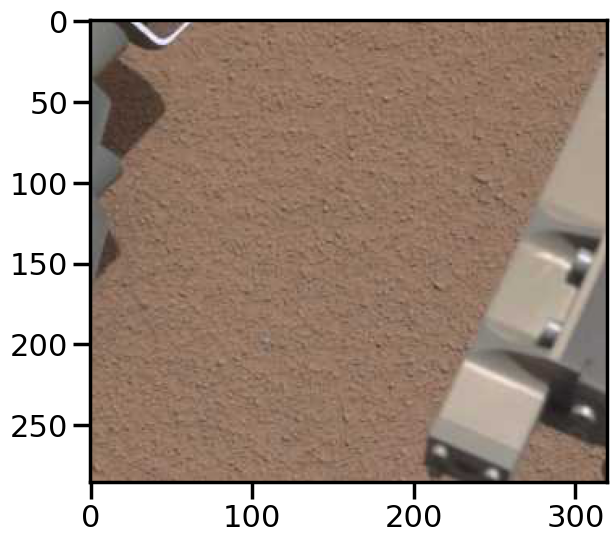

In [16]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [24]:
image_array = np.array(Im_1)
print(image_array[:,:,0])

[[132 131 130 ... 144 142 140]
 [132 131 130 ... 150 144 139]
 [131 130 129 ... 151 142 134]
 ...
 [153 155 158 ... 122  91  68]
 [151 154 157 ... 127  94  63]
 [153 154 155 ... 127  97  64]]


In [28]:
image_array = np.array(Im_1)
min_rgb=np.min(image_array, axis=2)
R, G, B = image_array[:,:,0], image_array[:,:,1], image_array[:,:,2]

I=(R+G+B)/3
S = 1 - I*min_rgb


- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

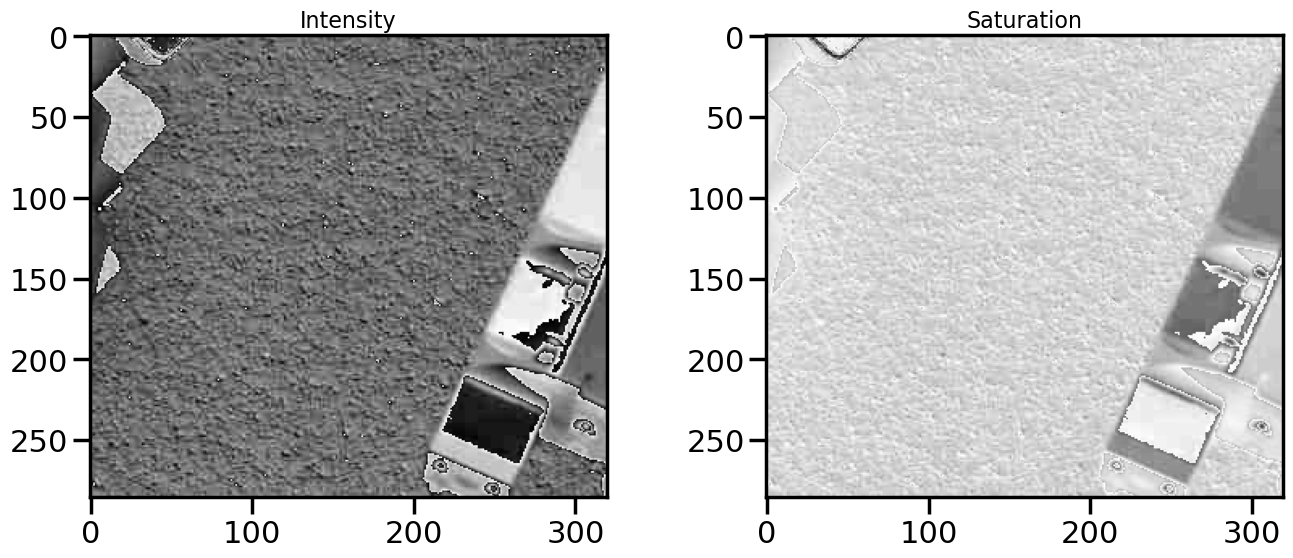

In [29]:
# TODO
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Intensity', size=16)
ax[1].imshow(S, cmap='gray')
ax[1].set_title('Saturation', size=16)
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from hdbscan import HDBSCAN 


n, p = I.shape
pixel_features = np.vstack((I.flatten(), S.flatten())).T

# K-Means
kmeans_labels = KMeans(n_clusters=4, n_init='auto', random_state=42).fit_predict(pixel_features)
kmeans_segmented = kmeans_labels.reshape((n, p))

# DBSCAN
dbscan_labels = DBSCAN(eps=0.03, min_samples=100).fit_predict(pixel_features)
dbscan_segmented = dbscan_labels.reshape((n, p))

# HDBSCAN
hdbscan_labels = HDBSCAN(min_cluster_size=100, algorithm='boruvka_kdtree').fit_predict(pixel_features)
hdbscan_segmented = hdbscan_labels.reshape((n, p))


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(kmeans_segmented, cmap='viridis')
axes[0].set_title('K-Means')

axes[1].imshow(dbscan_segmented, cmap='viridis')
axes[1].set_title('DBSCAN')

axes[2].imshow(hdbscan_segmented, cmap='viridis')
axes[2].set_title('HDBSCAN')

plt.suptitle('Comparaison des Segmentations')
plt.show()



ModuleNotFoundError: No module named 'hdbscan'

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

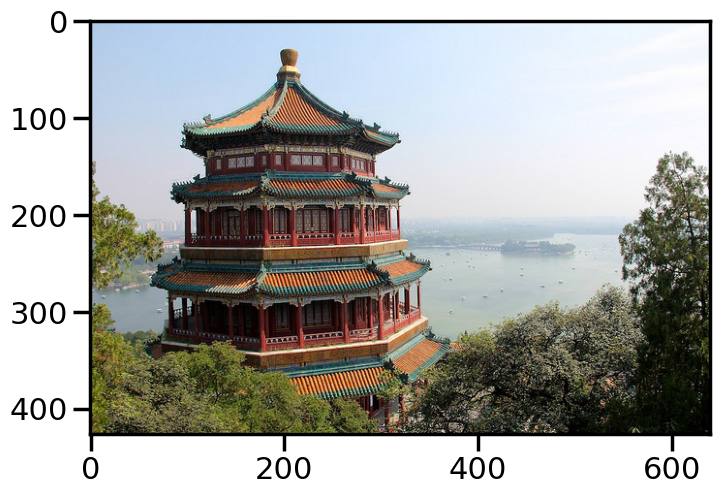

In [34]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


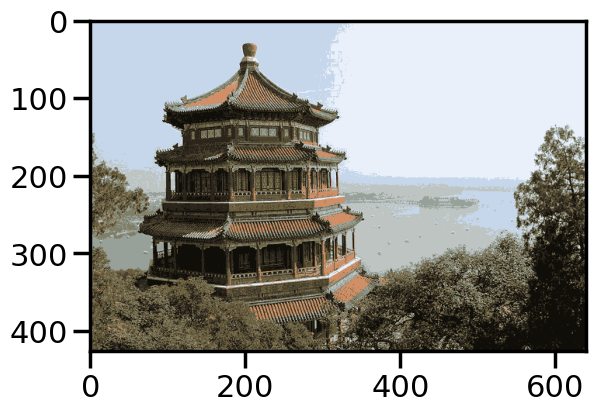

In [47]:
H,L = china.shape[:2]
array = china.reshape(-1,3)
cluster = KMeans(n_clusters=10)
labels = cluster.fit_predict(array)
china_compressed = cluster.cluster_centers_[labels].reshape(H,L,3)/255
plt.imshow(china_compressed)